# Queuing Theory

... an empirical approach

by Heinrich Hartmann

SRECon Europe 2017
Dublin Ireland

# Introduction

A queueing system consists of a queue and a number of servers.
Customers arrive at the queue and wait until the server is ready to service the customer.
After the customer has been served he leaves the system.

A queueing system, might contain multiple queues and multiple servers.
In more complex scenario, multiple queues are present, and requests are routed between them.

> Diagram: Symbolic Queue

## Kendals notation


Queuing systems are rougly classified by the following three parameters

`A/B/m`

where

* `A` arrival process (e.g. Poisson (M), General(G))
* `B` service time distribution (e.g. Exponential(M), Deterministic(D), General (G))
* `m` number of servers

We will be mainly concerned with `M/D/1` and `M/M/1` queues.

Reference: https://en.wikipedia.org/wiki/Kendall%27s_notation

## Examples of Queueing systems

1. A web server (Apache vs. Node)

1. CPU run queue (multiple CPUs)

1. Request queue for disk

1. Network buffers

1. Waiting lines at the super-market

## Basic Questions

1. How long do customers have to wait to be serviced? (API performance)

1. How much more load can the server take?

1. How much do additional servers decrease the wait time?

# Terminology

## Request View

Each customer $c$ runs throught the following states:

* initial state (pre-arrival)
* Waiting in Queue
* Service in progress
* Departed (terminal state)

The service transition times are denoted by:

* the arrival time
* the service time
* the departure time

And the state durations are

* the residence duration, or total waiting duration $W(c)$
* the waiting in queue duration $W_q(c)$
* the service duration $S(c)$

So that:

$$ W(c) = W_q(c) + S(c) $$

### Customer Averages

Order the customers by time of arrival $c=1,2,\dots$, then

$$ W = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N W(c) $$

$$ W_q = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N W_q(c) $$

$$ S = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N S(c) $$

Again we have:

$$ W = W_q + S $$

## System View

### Arrival Pattern

There are two possible scenarios we will consider:

* (a) The arrivals are given to us as input data, e.g. from log files
* (b) The arrivals are sampled from a propability distribution

In the second case we will assume that the generating process has nice properties (Stationary, Ergodic or Poisson process)

Notation:

* Arrival function $$N(t) = \# \{ \text{ customers that arrived before time $t$ } \} = N([0,t))$$

In analogy we can also consider:

* Servicing function $$N_S(t) = \# \{ \text{ customers that started service before time $t$ } \} $$
* Departure function $$M(t) = \# \{ \text{ customers that depated before time $t$ } \} $$

> image

### Arrival Rate

The arrival rate $\lambda$ is the average number of requests that are arriving at the system.
It can be defined as:

$$ \lambda = \lim_{t\rightarrow \infty} \frac{N(t)}{t} $$

The departure rate also known as throughput and denoted by:

$$ X = \lim_{t\rightarrow \infty} \frac{M(t)}{t} $$

In [106]:
#
# Simulating Queues
#

# show graphics inside Jupyter Notebook
%matplotlib inline 

import numpy as np             # np.array()
import matplotlib.pylab as plt # plotting
from scipy import stats        # probability distributions
from itertools import *        # islice

In [299]:
#
# The arrival process is modeled as iterator
#
def IID(Dist):
    while True:
        yield Dist()

def Const(c):
    "Constant series"
    return IID(lambda: c)

def Ber(p):
    "Bernoulli noise"
    return IID(stats.bernoulli(p).rvs)

def Poi(l):
    "Poisson noise"
    return IID(stats.poisson(l).rvs)

def ExampleData():
    # could be extracted from log files, etc.
    return [0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

In [300]:
# each call to next represents the arrival at a (1 minute) time window
next(Ber(0.2))

1

In [301]:
# Sampling Helper
def Sample(I, N=1000):
    return np.array(list(islice(I,N)))

In [302]:
Sample(Ber(0.2), 50)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0])

In [303]:
# Visualize Arrival Process
def Plot(I, *args, **kwargs):
    N = kwargs.pop("N", 1000)
    Y = Sample(I,N)
    X = range(len(Y))
    plt.figure(0, figsize=(20,4)) # always use figure 0
    plt.step(X, Y, *args, **kwargs)

def Hist(I, *args, **kwargs):
    N = kwargs.pop("N", 1000)
    # setup plot
    plt.figure(1, figsize=(10,5))
    kwargs['bins'] = int(kwargs.get('bins', np.sqrt(N)))
    H = plt.hist(Sample(I,N), *args, **kwargs)

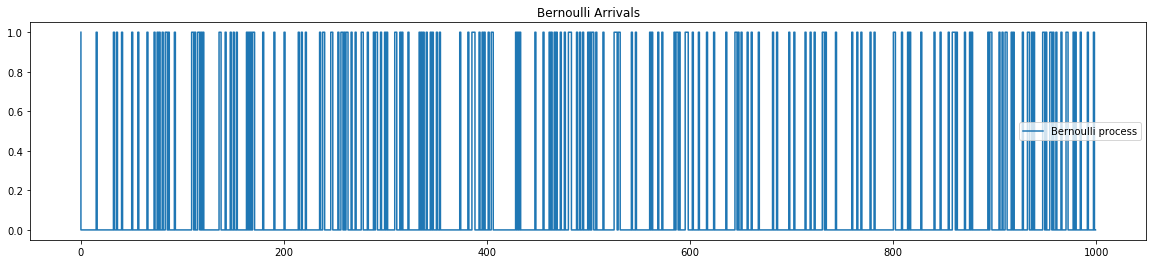

In [304]:
Plot(Ber(0.2))
plt.title("Bernoulli Arrivals")
plt.legend(["Bernoulli process"])

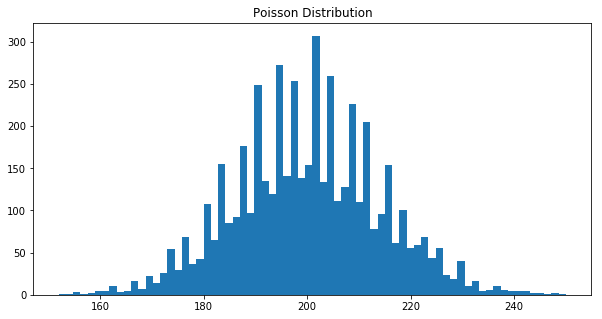

In [305]:
Hist(Poi(200), N=5000)
plt.title("Poisson Distribution")

In [306]:
#
# Computing N(t) and the arrival rate
#
def walk(I):
    s = 0
    for y in I:
        s += y
        yield s

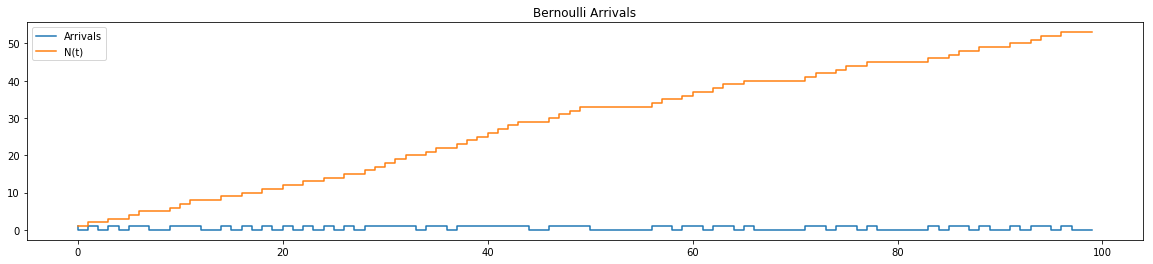

In [307]:
# Simulating Bernoulli arrivals
p = 0.5
N = 100
arrivals    = Sample(Ber(p), N) # arrivals per minute
arrivals_nt = walk(arrivals)    # N(T)
Plot(arrivals)
Plot(arrivals_nt)
plt.title("Bernoulli Arrivals")
plt.legend(["Arrivals", "N(t)"])

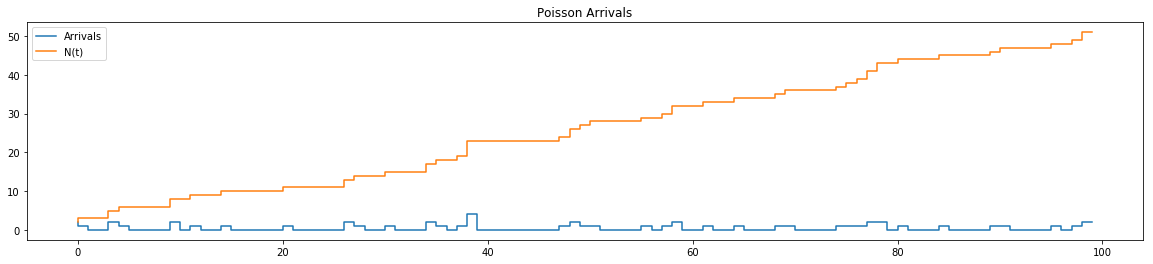

In [308]:
# Simulating Poisson arrivals
p = 0.5
N = 100
arrivals    = Sample(Poi(p), N) # arrivals per minute
arrivals_nt = walk(arrivals)    # N(T)
Plot(arrivals)
Plot(arrivals_nt)
plt.title("Poisson Arrivals")
plt.legend(["Arrivals", "N(t)"])

In [348]:
#
# Arrival rate
#
def time_average(I):
    t = 0.
    s = 0.
    for y in I:
        t += 1
        s += y
        yield float(s)/t

def tail(I, n=-1):
    y_last = None
    t = 0
    for y in I:
        t += 1
        y_last = y
        if t == n:
            break
    return y_last

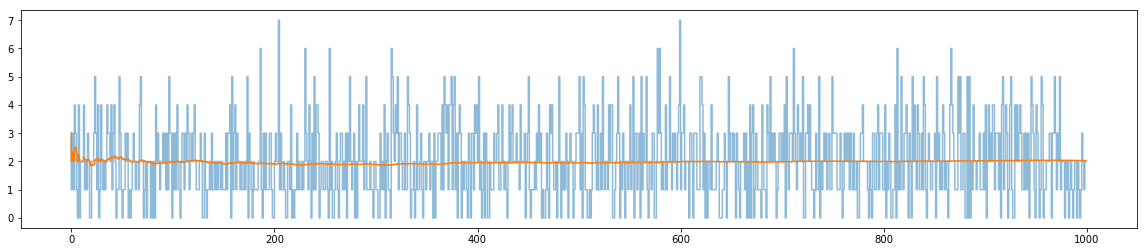

Simulated Arrival Rate:  2.013


In [427]:
p = 2
N = 10000
arrivals    = Sample(Poi(p), N) # arrivals per minute
arrivals_ta = time_average(arrivals) # N(T)
Plot(arrivals, alpha=0.5)
Plot(arrivals_ta)
plt.show()
print("Simulated Arrival Rate: ", last(time_average(arrivals)))
# Hist(arrivals)

In [350]:
#
# Queue implementation
#

# ?/D/1 Queue
# constant service time
def QD1(I, service_time):
    q = 0
    s = -1 # service timer
    for a in I:
        q += a # enqueue arrivals
        s -= 1 # service 'tick'

        # check service timer
        if s == 0:
            yield 1
        else:
            yield 0

        # service next customer
        if s <= 0 and q > 0:
            q -= 1
            s = service_time

# ?/M/1
# Markov (geometric) service times
def QM1(I, S):
    q = 0
    s = -1 # service timer
    for a in I:
        q += a # enqueue arrivals
        s -= 1 # service 'tick'

        # check service timer
        if s == 0:
            yield 1
        else:
            yield 0

        # service next customer
        if s <= 0 and q > 0:
            q -= 1
            s = stats.geom.rvs(1/S)

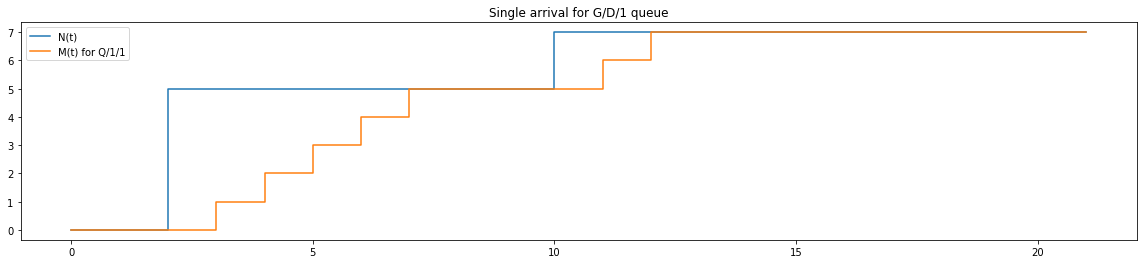

In [351]:
# Constant service duration
A = ExampleData()
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QD1(A, 1)));   legend.append("M(t) for Q/1/1")
#Plot(walk(QD1(A, 2)));   legend.append("M(t) for Q/2/1")
#Plot(walk(QD1(A, 3)));   legend.append("M(t) for Q/3/1")
plt.title("Single arrival for G/D/1 queue")
plt.legend(legend)

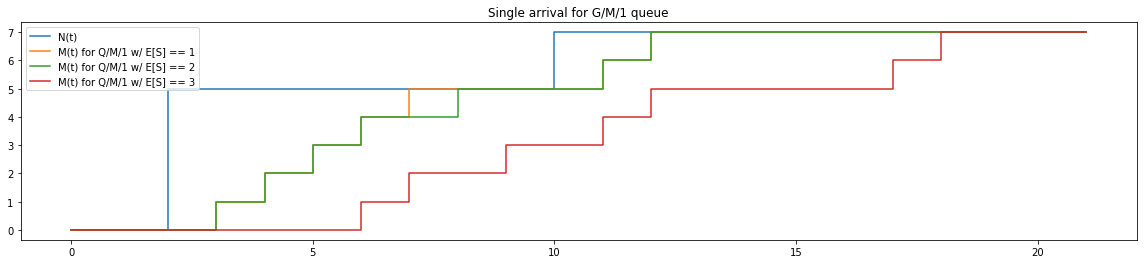

In [365]:
# Random service duration
A = ExampleData()
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QM1(A, 1)));   legend.append("M(t) for Q/M/1 w/ E[S] == 1")
Plot(walk(QM1(A, 2)));   legend.append("M(t) for Q/M/1 w/ E[S] == 2")
Plot(walk(QM1(A, 3)));   legend.append("M(t) for Q/M/1 w/ E[S] == 3")
plt.title("Single arrival for G/M/1 queue")
plt.legend(legend)


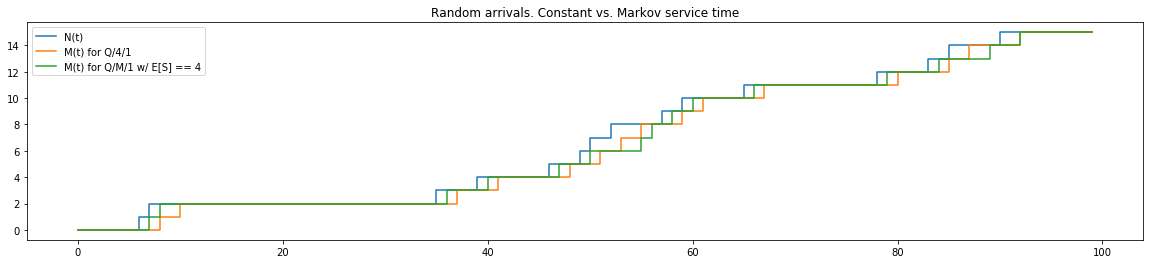

In [366]:
# Random arrivals, Constant vs. Random service durations
A  = Sample(Poi(0.2), 100)
S = 2
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QD1(A, S)));   legend.append("M(t) for Q/4/1")
Plot(walk(QM1(A, S)));   legend.append("M(t) for Q/M/1 w/ E[S] == 4")
plt.title("Random arrivals. Constant vs. Markov service time")
plt.legend(legend)

Arrival rate: 0.23
Throughput:   0.095


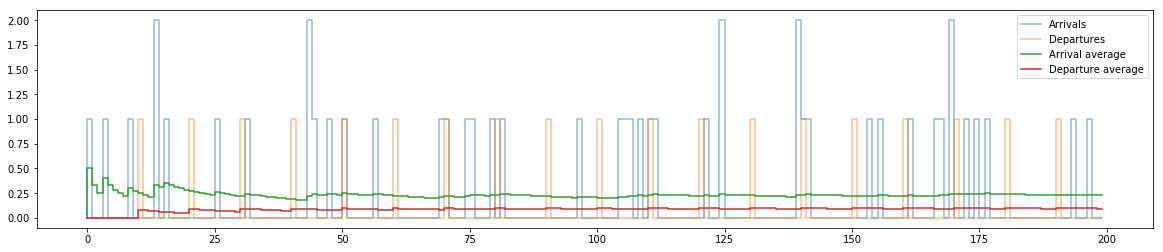

In [423]:
#
# Throughput is the rate of departures
#
A = Sample(Poi(0.2), 200)
S = 10
D = Sample(QD1(A, S))
legend = []
Plot(A, alpha=0.5); legend.append("Arrivals")
Plot(D, alpha=0.5); legend.append("Departures")
Plot(time_average(A)); legend.append("Arrival average")
Plot(time_average(D)); legend.append("Departure average")
plt.legend(legend)
print("Arrival rate:", last(time_average(A)))
print("Throughput:  ", last(time_average(D)))

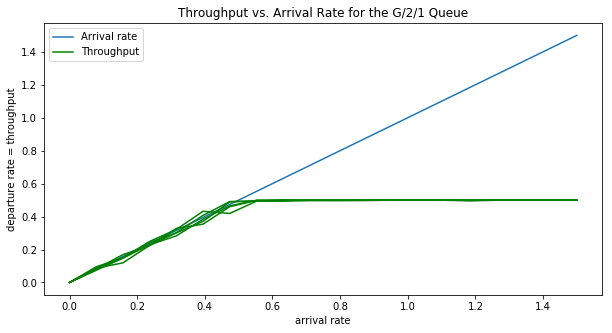

In [484]:
#
# Throughput depending on arrival rate
#

# arrival rate span
L = np.linspace(0, 1.5, 20)
service_time = 2
trials = 5

plt.figure(0, figsize=(10,5))
plt.plot(L,L)
for i in range(trials):
    Y = [ tail(time_average(QD1(Poi(l), service_time)), n=1000) for l in L ]
    plt.plot(L,Y, color="green")

plt.legend(["Arrival rate","Throughput"])
plt.title("Throughput vs. Arrival Rate for the G/2/1 Queue")
plt.xlabel("arrival rate")
plt.ylabel("departure rate = throughput")

### Queue length

From the perspective of the system we have:

* The concurrency $$L(t) = \# \{ \text{ customers inside the system at time $t$} \}$$

* The queue length $$L_q(t) = \# \{ \text{ customers waiting in the queue at time $t$} \}$$

* The service length $$L_s(t) = \# \{ \text{ customers being served at time $t$ } \}$$

We have:
$$ L(t) = L_q(t) + L_s(t) $$

### Utilization

Note that

* $L_s(t) \leq \text{(number of servers)}$ 
* $L_s(t) > 0$ whenever the system is busy


Let $busy(t) = 1$ if the system is busy ($L_s(t) > 0$) and 0 otherwise.
The integral average of $busy(t)$ over a time interval $I=[t_1, t_2]$ is called utilization:

$$ \rho(I) = \frac{\int_{t_1}^{t_2} busy(t) dt}{t_2 - t_1}, $$

In case we have a single server, this gives $\rho(I) = \frac{\int_{t_1}^{t_2} L_s(t) dt}{t_2 - t_1}.$

### Application: Computing Disk Utilization

In monitoring applications we are often interested in the utilization across intervals of 1 minute.
To get a precise estimate, consider the following function:

$$ F(T) = \int_0^T L_s(t) dt $$

The utilization can be calculated as discrete derivative:

$$ \rho(I) = \frac{F(t_2) - F(t_1)}{t_2 - t_1} $$

It turns out that this function can be tracked efficiently within an application, since:

$$F(T+\Delta T) = F(T) + L_s(T) \Delta T $$

if $L_s(t)$ is constant within $T, T+\Delta T$. Hence, $F(T)$ can be tracked by incrementing
$L_s(T) \Delta T$ eacht time a new customer is served. The average utilization can then
be derived as $\rho(I) = F(t_2) - F(t_1).$

The same reasoning can be applied to the average queue length, and is method is used by the Linux kernel/iostat to track average queue sizes for disks: https://www.circonus.com/2017/07/monitoring-queue-sizes/

### Time Averages

We can look at the following time Averages

* Average concurrency $$ L = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L(t) dt $$
* Average  queue length $$ L_q = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L_q(t) dt $$
* Average utilization $$ L_s = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L_s(t) dt $$

There are two interpretations of these limits possibe. In practice, we hava finite dataset so the
limit is just finite. In theory, we generate our requests by a probabilistic process, which we
assume to be stationary and ergodic so the above limits exists and are finite.

In [530]:
#
# Queue Lengths
#
def QL(N, M):
    # assumes N, M are already samples
    return N - M

def QLs(N, M):
    return QL(N, M) > 0

def QLq(N, M):
    return QL(N, M) - QLs(N, M)


Utilization:      rho = Ls =  0.52
Average Queue Length:   Lq =  0.12
Average Service Length: L  =  0.64


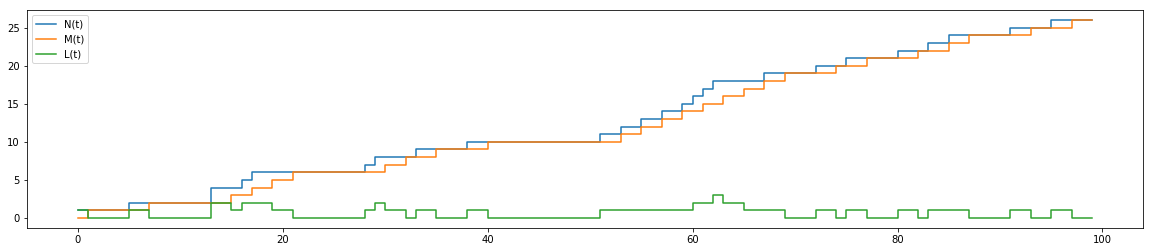

In [531]:
n = 100
l = 0.2
S = 2
A = Sample(Poi(l), n)
D = Sample(QD1(A, S), n)
N = Sample(walk(A), n)
M = Sample(walk(D), n)
legend = []
Plot(N); legend.append("N(t)")
Plot(M); legend.append("M(t)")
Plot(QL(N, M)); legend.append("L(t)")
#Plot(Lq(N, M)); legend.append("Lq(t)")
#Plot(-1*Ls(N, M)); legend.append("-Ls(t)")
plt.legend(legend)
print("Utilization:      rho = Ls = ", QLs(N,M).mean()) # same as last(time_average(Ls(N,M)))
print("Average Queue Length:   Lq = ", QLq(N,M).mean())
print("Average Service Length: L  = ", QL(N,M).mean())

In [558]:
#
# UNIX Load Averages
#
def smooth(I, alpha):
    "exponential smoothing formula"
    s = next(I)
    for y in I:
        s = alpha * y + (1-alpha) * s
        yield s

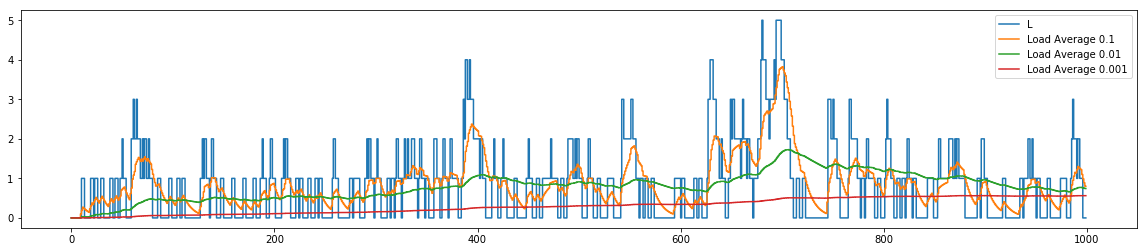

In [657]:
n = 5000
l = 0.2
S = 3
A = Sample(Poi(l), n)
D = Sample(QD1(A, S), n)
N = Sample(walk(A), n)
M = Sample(walk(D), n)
L = QL(N,M)
legend = []
Plot(L); legend.append("L")
Plot(Sample(smooth(iter(L), 0.1), n)); legend.append("Load Average 0.1")
Plot(Sample(smooth(iter(L), 0.01), n)); legend.append("Load Average 0.01")
Plot(Sample(smooth(iter(L), 0.001), n)); legend.append("Load Average 0.001")
plt.legend(legend)

In [586]:
# -> Circonus Example

# Little's Law

Little proved in 1960 some fundamental relations between the time averages and the customer averages

1. $ L   = \lambda \cdot W   $
1. $ L_q = \lambda \cdot W_q $
1. $ \rho = L_s = \lambda \cdot S $

> Drawing, graphical explanation

In [594]:
#
# Waiting durations
#
def W(N, M):
    "returns the average system duration"
    total_wait = QL(N,M).sum()
    total_customers = N[-1]
    return total_wait / total_customers

# * The service time (S) is a parameter in our models
# * The wait time in Queue can be computed as Wq= W - S

In [606]:
l = 0.2
S = 3
A = Sample(Poi(l), n)
D = Sample(Q(A, S), n)
N = Sample(walk(A), n)
M = Sample(walk(D), n)
print("Arrival Rate           lambda     =", l)
print("Average Waite Time     W          =", W(N,M))
print("Average Queue Length   L          =", QL(N,M).mean())
print("                       lambda * W =", W(N,M) * l)

Arrival Rate           lambda     = 0.2
Average Waite Time     W          = 6.20020533881
Average Queue Length   L          = 1.2078
                       lambda * W = 1.24004106776


# Expected Waiting time

### Case M/D/1

Consider an M/D/1 queue, with arrival rate $\lambda$ and constant service time $S$.

Q: What is the average time $W$ a customer resides in the system?

We assume $\rho = \lambda \cdot S < 1$, since otherwise the load can't be served, and the system is not stable.

The expected number of customers in the queue at arrival is $L_q$ (PASTA property of Poisson
Process).
Hence, the expected wait time, caused by customers in the queue is $L_q \cdot S$.

In addition we have to consider the wait time caused by current customer being serviced (in case there is one) and the time needed to service the customer itself (=S). So in total we find:

$$ W = L_q S + P[\text{server busy}] E[\text{residual service time}|\text{server busy}] + S$$

Now, $P[\text{server busy}] = \rho$ by PASTA. Moreover, if the server is busy we are in the middle
of service duration of length $S$, and we expect a residual service time of $S/2$, so:

$$ W = L_q S + \rho \cdot S/2 + S $$

Substituting Little's formula $L_q = \lambda W_q$ for $L_q$, and $W=W_q +S$  we find:

$$ W = S + \frac{\rho}{2} \frac{1}{1-\rho} S$$

### Case M/M/1

The expected wait time depends on the service time distribution. With exponential service distribution have:

$$ W = S + \frac{\rho}{1-\rho} S = \frac{1}{1-\rho} S $$

A particularly nice formula.
Note that we precisely double the expected *queue* wait duration (factor $1/2$) compared to the M/D/1 case.

### Case M/G/1


In general Variance in the service time causes higher expected wait times.
In general we have (Pollazek-Kinchine Formula):

$$ W = S + \frac{\rho}{2} {\frac  {1 + {\text{Var}}(S) / S^2}{1 - \rho}} S. $$

cf. Wikipedia https://en.wikipedia.org/wiki/Pollaczek–Khinchine_formula

* We recover the M/D/1 formula with $Var(S) = 0$
* We recover the M/M/1 formula with $Var(S) = S^2$
* Note that queuing duration is growing increasing $Var(S)$.

Desmos: https://www.desmos.com/calculator/bab6ujcrnd

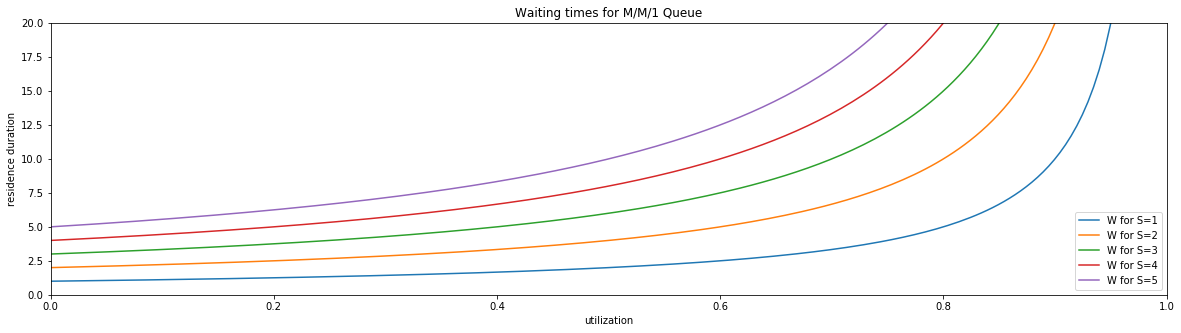

In [590]:
def W_theory(S, rho):
    return 1/(1-rho)*S

def plot_W(S):
    X = np.linspace(0, 0.9999,200)
    Y=[ W_theory(S, x)  for x in X ]
    plt.plot(X,Y)

plt.figure(figsize=(20,5))
plt.title("Waiting times for M/M/1 Queue")
legend = []
plot_W(1); legend.append("W for S=1");
plot_W(2); legend.append("W for S=2");
plot_W(3); legend.append("W for S=3");
plot_W(4); legend.append("W for S=4");
plot_W(5); legend.append("W for S=5");
plt.legend(legend)
plt.ylim(0,20)
plt.xlim(0,1)
plt.ylabel("residence duration")
plt.xlabel("utilization")

In [592]:
fmt = "{:>10} | {:>10.5} "
S = 1
def print_W(rho):
    print(fmt.format(rho, W_theory(S, rho)))
    
print("Notable Examples")
print(fmt.format("rho", "W"))
print("-"*25)
print_W(0)
print_W(0.5)
print_W(3/4)
print_W(0.90)
print_W(0.99)

Notable Examples
       rho |          W 
-------------------------
         0 |        1.0 
       0.5 |        2.0 
      0.75 |        4.0 
       0.9 |       10.0 
      0.99 |      100.0 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(0, 0.8)

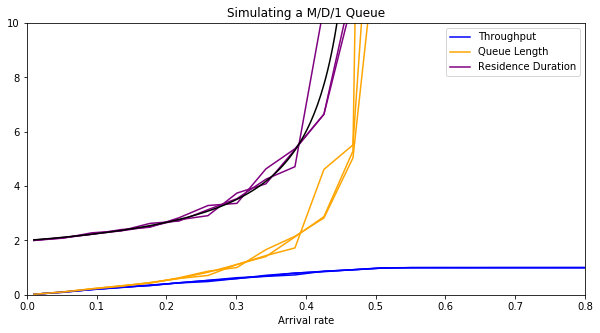

In [659]:
#
# Littles Law
#

# arrival rates
X = np.linspace(0.01, 0.8, 20)
S = 2
trials = 3
n = 5000

def W_theory(S, L):
    RHO = L*S
    return S + 1/2 * RHO/(1-RHO) * S

legend = []
plt.figure(figsize=(10,5))
for i in range(trials):
    buf_L  = []
    buf_W  = []
    buf_Ls = []
    buf_Wt = []
    for l in X:
        A = Sample(Poi(l), n)
        D = Sample(QD1(A, S), n)
        N = Sample(walk(A), n)
        M = Sample(walk(D), n)
        buf_L.append(QL(N,M).mean())
        buf_W.append(W(N,M))
        buf_Ls.append(QLs(N,M).mean())
    
    plt.plot(X, buf_Ls,  color = "blue")
    plt.plot(X, buf_L,   color = "orange")
    plt.plot(X, buf_W,   color = "purple")

X = np.linspace(0.01, 1/S, 200)
plt.plot(X, W_theory(S, X), color = "black")

plt.legend(["Throughput",  "Queue Length", "Residence Duration"])
plt.title("Simulating a M/D/1 Queue")
plt.xlabel("Arrival rate")
plt.ylim(0, 10)
plt.xlim(0, 0.8)

# Scalability Analysis

The maximal throughtput of a M/G/1 queue is $1/E[S] = \mu$, the service rate.

When we want to serve more incoming requests at a sensible residence time we have to add capacity to the queing system.

There are three main ways to do that:

- (A) Reduce the service time: $S \rightarrow S/m$ (if this is possible)
- (B) Add more queues $(M/G/1)\times m$
- (C) Add more servers $M/G/m$

### Change of throughput

In all three cases the maximal throughput *scales linearly*:

$$ X(m) = m \cdot \mu $$

### Change of Residence Duration

The differences lie in the average residence durations:

* Case A: Replacing $S$ by $S/m$ we find:

  $$ W = \frac{1}{m\mu - \lambda} $$

* Case B: Each queue is serving a fraction of the load, so we can replace $\lambda$ by $\lambda/m$ to get:

  $$ W = \frac{1}{\mu - \lambda/m} = \frac{m}{m \mu - \lambda} = m W_A $$

* Case C: The derivation of this is due to Erlang in 1907 and involves horrendous formulas. We just give an approximation here:

  $$ W \approx \frac{S}{1 - \rho^m} = \frac{1}{\mu} \frac{(m \mu)^m}{(m \mu)^m - \lambda^m} $$

How do these compare to each other?

Desmos: https://www.desmos.com/calculator/qpbnllcyeo

# Scalability Laws

In paractice we will seldom achieve linear scalability, since our workload is not fully paralelizable.
If there is a fraction $\sigma$ of the workload that needs to be done serially, then the maximal speedup we can expect is:

$$  X(m, \sigma) = \mu \frac{m}{1 + \sigma (m - 1)}$$

This result is known as *Ahmdals Law*.

In addition to the serial fraction, most systems require a certain amount of *crosstalk* $\kappa$ between the
nodes, in order to function, in this case the throughput can even degrade with increasing concurrency $m$:

$$ X(m, \sigma, \kappa) = \mu \frac{m}{1 + \sigma(m-1) + \kappa m(m-1)} $$

This result is known as the *Universal Scalability Law*.

Explore: https://www.desmos.com/calculator/pntup6jbhw